In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import glob
import itertools
import sklearn
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import decimal

In [129]:
data_with_time_features_final = pd.read_csv('divvy_agg_features.csv')

In [130]:
data_with_time_features_final['date_numeric'] = pd.to_datetime(data_with_time_features_final['date']).dt.strftime("%s")

In [131]:
data_with_time_features_final.head()

,station_id,date,hour,trips_departed,trips_arrived,Air Temperature,Humidity,Rain Intensity,Wind Speed,Interval Rain,...,arrived_ema_n,arrived_last_hour,arrived_last_hour_yesterday,net_bike_change,bike_change_ema_n,bike_change_last_hour,departures_over_capacity,arrivals_over_capacity,bike_change_over_capacity,date_numeric
0,2,2016-01-03,0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,-0.008789,0.0,0.0,0.0,0.0,1451800800
1,2,2016-01-03,1,0.0,0.0,-2.456667,69.333333,0.0,3.900000,0.0,...,0.0,0.0,0.0,0.0,-0.004395,0.0,0.0,0.0,0.0,1451800800
2,2,2016-01-03,2,0.0,0.0,-2.820000,70.666667,0.0,2.533333,0.0,...,0.0,0.0,0.0,0.0,-0.002197,0.0,0.0,0.0,0.0,1451800800
3,2,2016-01-03,3,0.0,0.0,-3.060000,70.000000,0.0,2.633333,0.0,...,0.0,0.0,0.0,0.0,-0.001099,0.0,0.0,0.0,0.0,1451800800
4,2,2016-01-03,4,0.0,0.0,-3.053333,68.333333,0.0,3.533333,0.0,...,0.0,0.0,0.0,0.0,-0.000549,0.0,0.0,0.0,0.0,1451800800


In [148]:
data_with_time_features_final.columns

Index(['station_id', 'date', 'hour', 'trips_departed', 'trips_arrived',
       'Air Temperature', 'Humidity', 'Rain Intensity', 'Wind Speed',
       'Interval Rain', 'latitude', 'longitude', 'Total Rain',
       'Precipitation Type', 'dpcapacity', 'day_of_week', 'month',
       'day_of_month', 'temp_last_hour', 'interval_rain_last_hour',
       'humidity_last_hour', 'rain_intensity_last_hour', 'departed_trips_sma',
       'departed_momentum', 'departed_ema_n', 'departed_last_hour',
       'departed_last_hour_yesterday', 'arrived_trips_sma', 'arrived_momentum',
       'arrived_ema_n', 'arrived_last_hour', 'arrived_last_hour_yesterday',
       'net_bike_change', 'bike_change_ema_n', 'bike_change_last_hour',
       'departures_over_capacity', 'arrivals_over_capacity',
       'bike_change_over_capacity', 'date_numeric'],
      dtype='object')

# Distribution of Departures and Arrivals
Before training models, let's look at the distribution of departures and arrivals
From the histograms it can be seen that there are very few departures/arrivals at any station more than 10 in an hour
This is useful because it can tell us where to cap our predictions. Regression results can be sensitive to outliers
so by capping predictions we can improve overall model performance

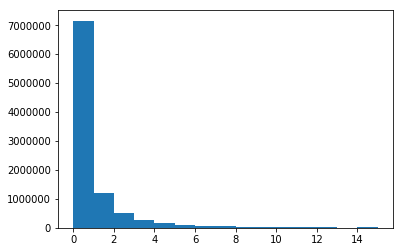

In [132]:
plt.hist(data_with_time_features_final['trips_departed'], bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

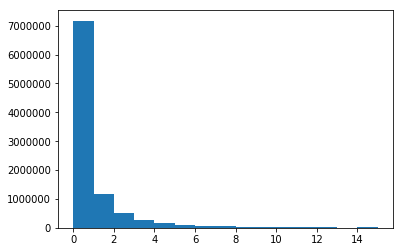

In [133]:
plt.hist(data_with_time_features_final['trips_arrived'], bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

Let's also look at only one station on a particular day to get a sense of what the distribution is like for that station on that day in terms of departures and arrivals. The station in question is on Wrightwood and Clark right next to where I live in Lincoln Park. This is a typical station which sees regular activity but is regularly full in the evenings when I return from work or is empty in the mornings when I am trying to get to work. Clearly not a good scenario for someone trying to commute to work.

From the chart it can be seen that at no point in the day do we have more than 10 departures or arrivals. Second departures peak in the mornings and arrivals peak in the evenings. This makes sense for residential neighborhoods because people are using divvys to commute to and from work like me.

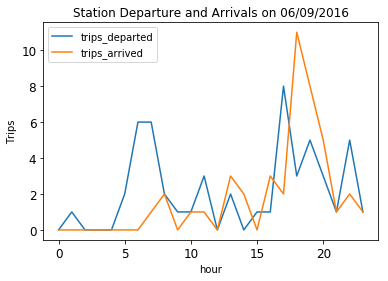

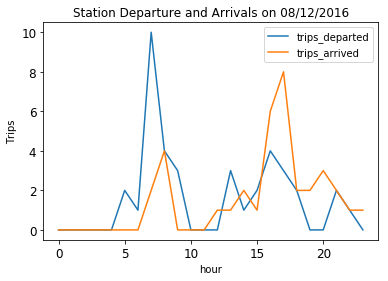

In [146]:
df = data_with_time_features_final[data_with_time_features_final['station_id'] == 340]
df = df[df['date'] == '2016-06-09']
df = df.filter(items = ['hour','trips_departed','trips_arrived'])
df = df.set_index('hour')
ax = df.plot(title='Station Departure and Arrivals on 06/09/2016', fontsize=12)
ax.set_xlabel('hour')
ax.set_ylabel('Trips')
plt.show()

df = data_with_time_features_final[data_with_time_features_final['station_id'] == 340]
df = df[df['date'] == '2016-08-12']
df = df.filter(items = ['hour','trips_departed','trips_arrived'])
df = df.set_index('hour')
ax = df.plot(title='Station Departure and Arrivals on 08/12/2016', fontsize=12)
ax.set_xlabel('hour')
ax.set_ylabel('Trips')
plt.show()

# Splitting the Data

First we train the data on all of 2016 only. The train data itself will then be randomly split into an actual train and validation data with a 70/30% ratio. The validation set is there to help us optimize on parameters and training
approaches.

The model will then be tested on all of 2017 data. By ensuring a full year of train and test it allows us to get a time series for the entire year so all seasonality is effectively captured in the training.

In [151]:
def create_train_vectors(train, valid, test, feature_scope):
    
    if feature_scope == 'all':
        x_train = train.iloc[:,np.r_[0,2,5:train.shape[1]]]
        x_valid = valid.iloc[:,np.r_[0,2,5:valid.shape[1]]]
        x_test = test.iloc[:,np.r_[0,2,5:test.shape[1]]]
    
    elif feature_scope == 'weather':
        x_train = train.iloc[:,np.r_[0,2,5:21]]
        x_valid = valid.iloc[:,np.r_[0,2,5:21]]
        x_test = test.iloc[:,np.r_[0,2,5:21]]
    
    elif feature_scope == 'station':
        x_train = train.iloc[:,np.r_[0,2,10,11,15,16,17,22:train.shape[1]]]
        x_valid = valid.iloc[:,np.r_[0,2,10,11,15,16,17,22:train.shape[1]]]
        x_test = test.iloc[:,np.r_[0,2,10,11,15,16,17,22:train.shape[1]]]

    ##scaling before training
    standard_scaler = preprocessing.StandardScaler(with_mean = True, with_std = True)
    x_train = standard_scaler.fit_transform(x_train)
    x_valid = standard_scaler.transform(x_valid)
    x_test = standard_scaler.transform(x_test)
    
    return x_train, x_valid, x_test

##creating train, test, valid vectors
train = data_with_time_features_final[data_with_time_features_final['date'] <= '2016-12-31']
test = data_with_time_features_final[data_with_time_features_final['date'] > '2017-01-01']

train, valid = train_test_split(train, test_size=0.3, random_state = 45)
x_train, x_valid, x_test = create_train_vectors(train, valid, test, 'all')

##departures to predict
y_train_depart = train.iloc[:,3]
y_valid_depart = valid.iloc[:,3]
y_test_depart = test.iloc[:,3]

##arrivals to predict
y_train_arrive = train.iloc[:,4]
y_valid_arrive = valid.iloc[:,4]
y_test_arrive = test.iloc[:,4]

In [152]:
print('Number of rows in Train Set: ' + str(train.shape[0]))
print('Number of rows in Validation Set :' + str(valid.shape[0]))
print('Number of rows in Test Set :' + str(test.shape[0]))

Number of rows in Train Set: 3227851
Number of rows in Validation Set :1383365
Number of rows in Test Set :5075616


# Baseline Performance

The second thing to note from the arrival and departure distribution is that most (>70%) of all (stations, days, hours) have no departures or arrivals. A simple naive baseline then would be to just predict 0 for every (station,day,hour). 

However, we can do better than that. Let's simply use the last hour's departure or arrival number as this hour's arrival or departure number or even better the departures or arrivals on this hour yesterday.

In [153]:
baseline = np.copy(y_valid_depart)
baseline[:] = 0
baseline[0:10]
print('The Naive Baseline MSE when predicting all zeros for departures is: ')
print(round(metrics.mean_squared_error(y_valid_depart, baseline),2))
baseline = valid['departed_last_hour']
print('The Better Baseline MSE when predicting the last hours departures/arrivals as this hours departure/arrival is: ')
print(round(metrics.mean_squared_error(y_valid_depart, baseline),2))

baseline = valid['departed_last_hour_yesterday']
print('The Final Baseline MSE when predicting departures/arrivals yesterday on this hour as this hours departure/arrival: ')
print(round(metrics.mean_squared_error(y_valid_depart, baseline),2))

The Naive Baseline MSE when predicting all zeros for departures is: 
6.63
The Better Baseline MSE when predicting the last hours departures/arrivals as this hours departure/arrival is: 
3.56
The Final Baseline MSE when predicting departures/arrivals yesterday on this hour as this hours departure/arrival: 
3.99


# Training a Linear Regression with Regularization

We now have a baseline in terms of MSE established. Whatever model we build should do significantly better than the 3.81 MSE we got from our baseline.

Next, I train a simple linear regression model with a regularization penalty to help achieve better generalization.
There are 3 models trained.

1) The first model includes all the features 
2) The second model only includes the weather features
3) The third model includes only station activity features

By looking at the performance of all 3 models we can see how much value was generated by deriving custom features for
this dataset.

In [154]:
def ridge_regression(x_train, x_valid, y_train, y_valid, alpha_val):
    #RIDGE REGRESSION
    ridge = Ridge(alpha=alpha_val, normalize=False)
    ridge.fit(x_train, y_train)
    y_pred = ridge.predict(x_valid)
    return y_pred

alpha_regularizer = 0.1
print('The model performance when using ALL FEATURES')
y_pred_ridge_depart = ridge_regression(x_train, x_valid, y_train_depart, y_valid_depart, alpha_regularizer)
print('The performance of the model for departures on validation set in terms of MSE:')
print(round(metrics.mean_squared_error(y_valid_depart, y_pred_ridge_depart),4))

y_pred_ridge_arrive = ridge_regression(x_train, x_valid, y_train_arrive, y_valid_arrive, alpha_regularizer)
print('The performance of the model for arrivals on validation set in terms of MSE:')
print(round(metrics.mean_squared_error(y_valid_arrive, y_pred_ridge_arrive),4))

The model performance when using ALL FEATURES
The performance of the model for departures on validation set in terms of MSE:
1.6079
The performance of the model for arrivals on validation set in terms of MSE:
1.6079


In [156]:
x_train, x_valid, x_test = create_train_vectors(train, valid, test, 'weather')
y_pred_ridge_weather = ridge_regression(x_train,x_valid, y_train_depart, y_valid_depart, a)
print('Model Performance with only Weather Features')
print(metrics.mean_squared_error(y_valid_depart, y_pred_ridge_weather))

x_train, x_valid, x_test = create_train_vectors(train, valid, test, 'station')
print('Model Performance with only Station Time Features')
y_pred_ridge_time_features = ridge_regression(x_train,x_valid, y_train_depart, y_valid_depart, a)
print(metrics.mean_squared_error(y_valid_depart, y_pred_ridge_time_features))

Model Performance with only Weather Features
5.173269099405395
Model Performance with only Station Time Features
1.617173437012434


From the above we can see that using all features is best for model performance. Using only weather features performs significantly worst than all features with MSE = 5.17. Using station features only still performs worse than using all features although only very slightly. From this we can see that the most value in terms of predictions is coming from station level features. If we were to improve the model, this is what we would try to focus on making better even more.

# Capping Outlier Predictions
Since there are very few departures or arrivals greater than 10 we will cap departures and arrivals to 15 to improve performance. This will be bad for the few stations that are tourist hubs where there are a ton of departures/arrivals but for most stations and on most days of the year, very few places will be seeing more than 15 arrivals/departures per hour. Moreoever, from a practical standpoint. It is more important to have our predictions more accurate for the most frequent occuring events. For a station with 15 arrivals or 20 arrivals the difference matters less than a station with 2 vs 4 arrivals. This is because the 2 vs 4 happens a lot while the 15 vs 20 will be once in a year on a tourist heavy station/day etc. That can be anticipated and mitigated.

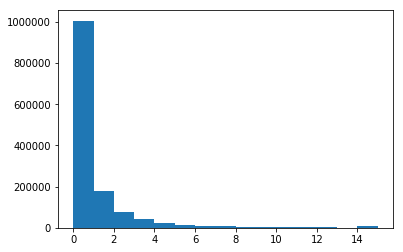

In [164]:
x_train, x_valid, x_test = create_train_vectors(train, valid, test, 'all')
cap = 15

##upper bound predicted variable
y_train_depart[y_train_depart>=cap] = cap
y_valid_depart[y_valid_depart>=cap] = cap
y_test_depart[y_test_depart>=cap] = cap

##upper bound predicted variable
y_train_arrive[y_train_arrive>=cap] = cap
y_valid_arrive[y_valid_arrive>=cap] = cap
y_test_arrive[y_test_arrive>=cap] = cap

plt.hist(y_valid_depart, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

In [158]:
y_pred_ridge_depart[y_pred_ridge_depart <0] = 0
y_pred_ridge_depart[y_pred_ridge_depart >=cap] = cap

print('The mean square error after capping improves to: ')
print(metrics.mean_squared_error(y_valid_depart, y_pred_ridge_depart))

The mean square error after capping improves to: 
1.0381437662791158


## Training a Random Forest

Now instead of linear regression, let's try a random forest for predictions. Random forests are a non parametric method that have the benefit of being less sensitive to outliers as we only split on values. 

Second, they are also good for predicting on datasets where a simple linear function is not obvious. Recall, the charts above which showed the distribution of arrivals and departures for a station on given days. The curve was not linear and peaked in the mornings and evenings. A simple linear regression may not always be good at identifying such non linear complexities.

Finallly, by also bagging many trees into one predictor we also reduce one of 2 sources of error: variance is reduced greatly while not affecting the bias necessarily. This leads to improved model performance.

In [142]:
def randomForestModel(trees, min_leaf, x_train, y_train, x_valid):
    rf = RandomForestRegressor(n_estimators = 25, random_state = 42, min_samples_leaf=5, verbose = 2)
    rf.fit(x_train, y_train)
    y_preds_rf = rf.predict(x_valid)
    return rf, y_preds_rf

In [143]:
x_train, x_valid, x_test = create_train_vectors(train, valid, test, 'all')
rf_arrive_model, rf_preds_arrive = randomForestModel(25, 5, x_train, y_train_arrive, x_valid)
rf_depart_model, rf_preds_depart = randomForestModel(25, 5, x_train, y_train_depart, x_valid)

building tree 1 of 25


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 31.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   11.5s finished


building tree 1 of 25


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 43.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   12.3s finished


## Evaluation of Random Forest Model
We can see that the random forest model greatly reduces the MSE on this dataset both in validation and testing to a much more impressive 0.71 for departures and 0.62 for arrivals. This is almost a 30% improvement. Unfortunately because training takes > 1 hour it is not feasible to do grid search on the parameter values here.

In [167]:
print('PERFORMANCE ON VALIDATION SET:')
print('THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR DEPARTURES:')
print(metrics.mean_squared_error(y_valid_depart, y_preds_rf))
print('THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR ARRIVALS:')
rf_preds_arrive[rf_preds_arrive <0] = 0
rf_preds_arrive[rf_preds_arrive >=cap] = cap
print(metrics.mean_squared_error(y_valid_arrive, rf_preds_arrive))

print('PERFORMANCE ON TEST SET 2017 Data:')
y_preds_rf_test_depart = rf.predict(x_test)
y_preds_rf_test_arrive = rf_arrive_model.predict(x_test)

y_preds_rf_test_depart[y_preds_rf_test_depart <0] = 0
y_preds_rf_test_depart[y_preds_rf_test_depart >=cap] = cap
y_preds_rf_test_arrive[y_preds_rf_test_arrive <0] = 0
y_preds_rf_test_arrive[y_preds_rf_test_arrive >=cap] = cap

print('THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR DEPARTURES:')
print(metrics.mean_squared_error(y_test_depart, y_preds_rf_test_depart))
print('THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR ARRIVALS:')
print(metrics.mean_squared_error(y_test_arrive, y_preds_rf_test_arrive))

PERFORMANCE ON VALIDATION SET:
THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR DEPARTURES:
0.7145663739042932
THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR ARRIVALS:
0.6196855233976661
PERFORMANCE ON TEST SET 2017 Data:


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   32.0s finished


THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR DEPARTURES:
0.6975665147661416
THE MEAN SQUARE FOR THE RANDOM FOREST MODEL FOR DEPARTURES:
0.5930470137809808


In [ ]:
test['departure_predictions'] = y_preds_rf_test_depart
test['arrival_predictions'] = y_preds_rf_test_arrive
test.head()
#print(metrics.mean_squared_error(test['trips_departed'] , test['departure_predictions']))
test.to_csv('test_predictions_rf.csv',index=False)

# Next Steps (TBD) - Evaluation of Model on Sub Cohorts

Now that we have a decent performing model, I will now try to better evaluate the model by seeing its performance across different slicers in 2017 test data. I will break down the performance of the model by the following:

    1) Each station on the map
    2) Each day of the week
    3) Each month of the year
    4) Each hour of the day
    5) By Station Size (Big,medium, small capacity)
    6) By Station Volume (Trips Taken)

The goal is to see where the model performs better and in which cohorts it performs poorly. This is very beneficial because it can tell us where and what we should be working on improving in the model.